In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download delayedkarma/impressionist-classifier-data
! unzip impressionist-classifier-data.zip

impressionist-classifier-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  impressionist-classifier-data.zip
replace training/training/Cezanne/215457.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import numpy as np
import pandas as pd
import os
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch import Generator
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import itertools
import time
import copy
from torchvision.models import ResNet50_Weights
from torch.nn import Module
from torchvision import models
import torch.optim as optim
import seaborn as sns
import torchvision
import torch.nn as nn
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [ ]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 6050
setup_seed(SEED)

In [ ]:
artists = ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']
artists = os.listdir('training/training')

In [ ]:
transformation = Compose([
    Resize((256,256)),
    ToTensor()
])
transformation_train = Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    ToTensor()
])

image_datasets = {}
# for phase in ['training', 'validation']:
#   image_datasets[phase] = ImageFolder(f'/content/{phase}/{phase}', transform=transformation)
image_datasets['training'] = ImageFolder(f'/content/training/training', transform=transformation_train)
image_datasets['validation'] = ImageFolder(f'/content/validation/validation', transform=transformation)

# size_all_train = len(image_datasets['training'])
# size_test_from_train = int(size_all_train * 0.125)
# size_train = size_all_train - size_test_from_train

# image_datasets['training'], image_datasets_test_from_train = random_split(image_datasets['training'], [size_train, size_test_from_train], generator=Generator().manual_seed(SEED))

# size_all_validation = len(image_datasets['validation'])
# size_test_from_validation = int(size_all_validation * 0.25)
# size_validation = size_all_validation - size_test_from_validation

# image_datasets['validation'], image_datasets_test_from_validation = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# image_datasets['testing'] = ConcatDataset([image_datasets_test_from_train, image_datasets_test_from_validation])

size_all_validation = len(image_datasets['validation'])
size_test_from_validation = int(size_all_validation * 0.5)
size_validation = size_all_validation - size_test_from_validation

image_datasets['validation'], image_datasets['testing'] = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# EDIT BATCH SIZE HERE (tune learning rate using 16, then, once the learning rate is fixed, try 32, 48, 64)
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'testing']}
print(dataset_sizes)

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'training': 3988, 'validation': 495, 'testing': 495}
cuda:0


In [ ]:
for artist in artists:
    exec(f"train_{artist}_dir = os.path.join('training/training', '{artist}')")
    exec(f"train_{artist}_filenames = os.listdir(train_{artist}_dir)")
    exec(f"valid_{artist}_dir = os.path.join('validation/validation', '{artist}')")
    exec(f"valid_{artist}_filenames = os.listdir(valid_{artist}_dir)")

In [ ]:
# define the model training function
def train_model(model, criterion, optimizer, num_epochs=25):
    # initialize the start time
    since = time.time()

    # initialize the best weight configuration and accuracy of the model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # initialize the lists that will store the accuracies and losses across the epochs
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    # iterate over the epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # initialize the running losses and corrects
            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass
                    # optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # calculate and update epoch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print epoch performance statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # store epoch performance statistics
            if phase == 'training':
              train_accs.append(epoch_acc.item())
              train_losses.append(epoch_loss)
            else:
              val_accs.append(epoch_acc.item())
              val_losses.append(epoch_loss)

            # deep copy the model to reflect the best weight configuration
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # print the training statistics
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, train_losses, val_accs, val_losses

In [ ]:
!pip install googlenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# global_LR = 5e-4
global_BS = 32
global_WD = 1e-5
global_DR = 0.0

In [ ]:
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [ ]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")
model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet


## Model 1: LR = 1e-5
- batch_size= 32
- WD = 1e-5
- Data Augmentation

In [ ]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
criterion_1 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
LR = 1e-5

# set the optimizer for the parameters of the whole model
optimizer_1 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=global_WD)

In [ ]:
model_1, train_accs_1, train_losses_1, val_accs_1, val_losses_1 = train_model(model_google, criterion_1, optimizer_1, num_epochs=10)

Epoch 1/10
----------
training Loss: 2.2682 Acc: 0.1472
validation Loss: 2.1472 Acc: 0.2020

Epoch 2/10
----------
training Loss: 2.0824 Acc: 0.2748
validation Loss: 1.9747 Acc: 0.3818

Epoch 3/10
----------
training Loss: 1.9222 Acc: 0.4017
validation Loss: 1.8388 Acc: 0.4646

Epoch 4/10
----------
training Loss: 1.8046 Acc: 0.4666
validation Loss: 1.7308 Acc: 0.5131

Epoch 5/10
----------
training Loss: 1.6981 Acc: 0.5160
validation Loss: 1.6262 Acc: 0.5515

Epoch 6/10
----------
training Loss: 1.6200 Acc: 0.5441
validation Loss: 1.5575 Acc: 0.5657

Epoch 7/10
----------
training Loss: 1.5450 Acc: 0.5695
validation Loss: 1.4994 Acc: 0.5818

Epoch 8/10
----------
training Loss: 1.4809 Acc: 0.5880
validation Loss: 1.4406 Acc: 0.5960

Epoch 9/10
----------
training Loss: 1.4309 Acc: 0.6073
validation Loss: 1.3878 Acc: 0.5939

Epoch 10/10
----------
training Loss: 1.3850 Acc: 0.6211
validation Loss: 1.3405 Acc: 0.6162

Training complete in 33m 26s
Best val Acc: 0.616162


Text(0.5, 1.0, 'Loss')

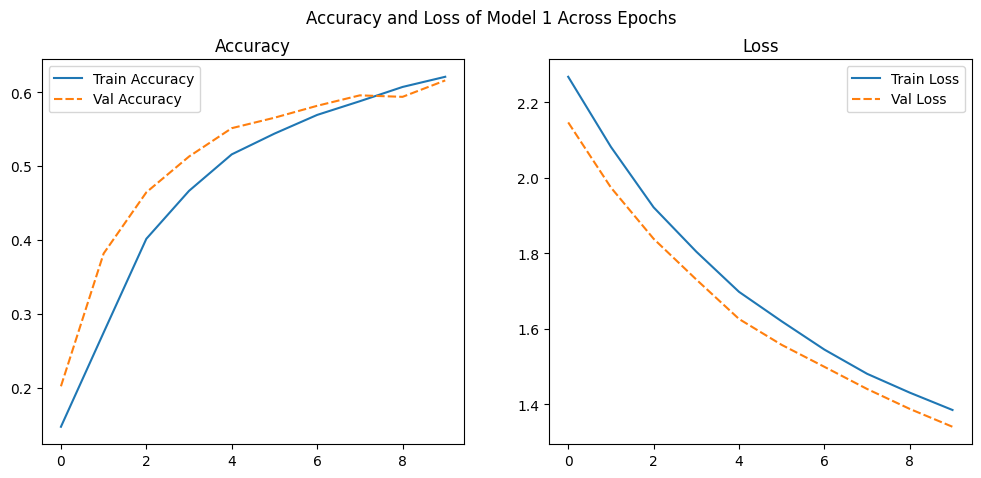

In [ ]:
data_acc_1 = pd.DataFrame({"Train Accuracy": train_accs_1, "Val Accuracy": val_accs_1})
data_loss_1 = pd.DataFrame({"Train Loss": train_losses_1, "Val Loss": val_losses_1})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 1 Across Epochs")

sns.lineplot(data=data_acc_1, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_1, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_1 = pd.concat([data_acc_1, data_loss_1], axis = 1)
result_1

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.147192,0.202020,2.268173,2.147220
1,0.274824,0.381818,2.082367,1.974663
2,0.401705,0.464646,1.922181,1.838780
3,0.466650,0.513131,1.804621,1.730763
4,0.516048,0.551515,1.698131,1.626204
5,0.544132,0.565657,1.619984,1.557549
6,0.569458,0.581818,1.545042,1.499357
7,0.588014,0.595960,1.480900,1.440642
8,0.607322,0.593939,1.430895,1.387753
9,0.621113,0.616162,1.384960,1.340467


## Model 2: LR = 1e-4
- batch_size= 32
- WD = 1e-5
- Data Augmentation

In [ ]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
criterion_2 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
LR = 1e-4

# set the optimizer for the parameters of the whole model
optimizer_2 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=global_WD)

In [ ]:
model_2, train_accs_2, train_losses_2, val_accs_2, val_losses_2 = train_model(model_google, criterion_2, optimizer_2, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.7700 Acc: 0.4491
validation Loss: 1.3572 Acc: 0.6000

Epoch 2/10
----------
training Loss: 1.2350 Acc: 0.6452
validation Loss: 1.0687 Acc: 0.6808

Epoch 3/10
----------
training Loss: 1.0125 Acc: 0.7064
validation Loss: 0.9325 Acc: 0.7374

Epoch 4/10
----------
training Loss: 0.8577 Acc: 0.7593
validation Loss: 0.8414 Acc: 0.7677

Epoch 5/10
----------
training Loss: 0.7556 Acc: 0.7821
validation Loss: 0.7441 Acc: 0.7717

Epoch 6/10
----------
training Loss: 0.6849 Acc: 0.8112
validation Loss: 0.7124 Acc: 0.7778

Epoch 7/10
----------
training Loss: 0.5972 Acc: 0.8302
validation Loss: 0.6972 Acc: 0.7657

Epoch 8/10
----------
training Loss: 0.5479 Acc: 0.8495
validation Loss: 0.6830 Acc: 0.7758

Epoch 9/10
----------
training Loss: 0.4791 Acc: 0.8651
validation Loss: 0.6470 Acc: 0.7939

Epoch 10/10
----------
training Loss: 0.4370 Acc: 0.8744
validation Loss: 0.6246 Acc: 0.7899

Training complete in 33m 1s
Best val Acc: 0.793939


In [ ]:
data_acc_2 = pd.DataFrame({"Train Accuracy": train_accs_2, "Val Accuracy": val_accs_2})
data_loss_2 = pd.DataFrame({"Train Loss": train_losses_2, "Val Loss": val_losses_2})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 2 Across Epochs")

sns.lineplot(data=data_acc_2, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_2, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_2 = pd.concat([data_acc_2, data_loss_2], axis = 1)
result_2

NameError: ignored

## Model 3: LR = 5e-4 ----- OPTIMAL MODEL
- batch_size= 32
- WD = 1e-5
- Data Augmentation

$\therefore$ 83.6% Validation Accuracy

## Model 4: LR = 1e-3
- batch_size= 32
- WD = 1e-5
- Data Augmentation

$\therefore$ 81.81% Validation Accuracy

In [ ]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
criterion_4 = nn.CrossEntropyLoss()

LR = 1e-3

# set the optimizer for the parameters of the whole model
optimizer_4 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=global_WD)

In [ ]:
model_4, train_accs_4, train_losses_4, val_accs_4, val_losses_4 = train_model(model_google, criterion_4, optimizer_4, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.2160 Acc: 0.6058
validation Loss: 0.8223 Acc: 0.7273

Epoch 2/10
----------
training Loss: 0.8253 Acc: 0.7392
validation Loss: 0.8234 Acc: 0.7131

Epoch 3/10
----------
training Loss: 0.6490 Acc: 0.7939
validation Loss: 0.7486 Acc: 0.7515

Epoch 4/10
----------
training Loss: 0.5826 Acc: 0.8124
validation Loss: 0.7133 Acc: 0.7677

Epoch 5/10
----------
training Loss: 0.5039 Acc: 0.8358
validation Loss: 0.6597 Acc: 0.7879

Epoch 6/10
----------
training Loss: 0.4034 Acc: 0.8751
validation Loss: 0.6772 Acc: 0.8000

Epoch 7/10
----------
training Loss: 0.3926 Acc: 0.8711
validation Loss: 0.6359 Acc: 0.8101

Epoch 8/10
----------
training Loss: 0.3389 Acc: 0.8887
validation Loss: 0.8150 Acc: 0.7758

Epoch 9/10
----------
training Loss: 0.3173 Acc: 0.8992
validation Loss: 0.7097 Acc: 0.8121

Epoch 10/10
----------
training Loss: 0.2893 Acc: 0.9015
validation Loss: 0.6712 Acc: 0.8182

Training complete in 33m 51s
Best val Acc: 0.818182


Text(0.5, 1.0, 'Loss')

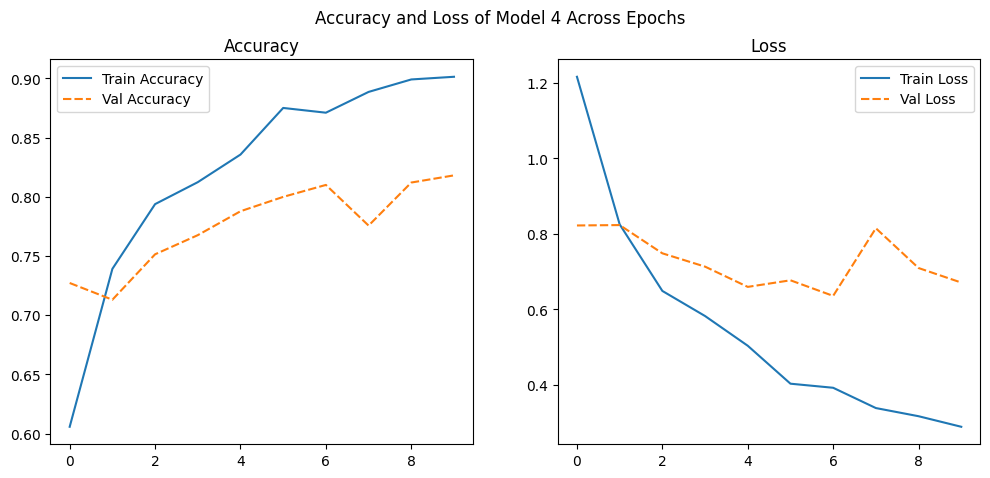

In [ ]:
data_acc_4 = pd.DataFrame({"Train Accuracy": train_accs_4, "Val Accuracy": val_accs_4})
data_loss_4 = pd.DataFrame({"Train Loss": train_losses_4, "Val Loss": val_losses_4})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 4 Across Epochs")

sns.lineplot(data=data_acc_4, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_4, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_4 = pd.concat([data_acc_4, data_loss_4], axis = 1)
result_4

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.605817,0.727273,1.216024,0.822338
1,0.739218,0.713131,0.825314,0.823390
2,0.793882,0.751515,0.649002,0.748593
3,0.812437,0.767677,0.582553,0.713324
4,0.835757,0.787879,0.503854,0.659729
5,0.875125,0.800000,0.403399,0.677167
6,0.871113,0.810101,0.392601,0.635870
7,0.888666,0.775758,0.338900,0.814985
8,0.899198,0.812121,0.317287,0.709656
9,0.901454,0.818182,0.289328,0.671164
